In [1]:
fff=!pwd
print(fff[0]+"/create_SIDER_side_effect_data.ipynb")

/workspace/02_cha_drug_repositioning/create_SIDER_side_effect_data.ipynb


In [2]:
%load_ext autoreload
%autoreload 2

# Imports

In [3]:
import numpy as np
import pandas as pd
import copy
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

from cmapPy.pandasGEXpress.parse import parse
from cmapPy.pandasGEXpress.write_gct import write
from cmapPy.pandasGEXpress.GCToo import GCToo
from cmapPy.pandasGEXpress.gctx2gct import gctx2gct_main

import torch

import warnings
warnings.filterwarnings('ignore')

/root/anaconda3/envs/py37/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from super_classes import param_class as param_class_module
from utils import data_processing as data_processing_module
from utils import data_load as data_load_module
from run import train as train_module
from run import test_model as test_model_module

# Configure parameters

In [5]:
BASE_DIR="/workspace/datafiles/2023/04/02_cha_drug_repositioning/paper_data"
GCTX_PATH_GSE70138="GSE70138_Broad_LINCS_Level4_ZSPCINF_mlr12k_n345976x12328_2017-03-06.gctx"
GCTX_PATH_GSE92742="GSE92742_Broad_LINCS_Level4_ZSPCINF_mlr12k_n1319138x12328.gctx"
TXT_META_PATH_GSE70138="GSE70138_Broad_LINCS_inst_info_2017-03-06.txt"
TXT_META_PATH_GSE92742="GSE92742_Broad_LINCS_inst_info.txt"
PERT_META_PATH_GSE70138="GSE70138_Broad_LINCS_pert_info_2017-03-06.txt"
PERT_META_PATH_GSE92742="GSE92742_Broad_LINCS_pert_info.txt"
TXT_LANDMARK_GENES_PATH="GSE92742_Broad_LINCS_gene_info_delta_landmark.txt"

Sent_FC_data="/workspace/datafiles/2023/04/02_cha_drug_repositioning/sent_data/DEG/GSE33814.csv"

In [6]:
configurable_parameters_dict={
  "BASE_DIR":BASE_DIR,
  "GCTX_PATH_GSE70138":GCTX_PATH_GSE70138,
  "GCTX_PATH_GSE92742":GCTX_PATH_GSE92742,
  "TXT_META_PATH_GSE70138":TXT_META_PATH_GSE70138,
  "TXT_META_PATH_GSE92742":TXT_META_PATH_GSE92742,
  "PERT_META_PATH_GSE70138":PERT_META_PATH_GSE70138,
  "PERT_META_PATH_GSE92742":PERT_META_PATH_GSE92742
}

In [7]:
current_drug="donepezil" # donepezil, galantamine, memantine

# Load data

In [8]:
df_drug_names=pd.read_csv("/workspace/datafiles/2023/04/02_cha_drug_repositioning/downloaded_data/drug_names.tsv",encoding='utf-8',sep='\t')
df_meddra_all_label_se=pd.read_csv("/workspace/datafiles/2023/04/02_cha_drug_repositioning/downloaded_data/meddra_all_label_se.tsv",encoding='utf-8',sep='\t')

In [9]:
df_drug_names

,drug_id,drug_name
0,CID100000085,carnitine
1,CID100000119,gamma-aminobutyric
2,CID100000137,5-aminolevulinic
3,CID100000143,leucovorin
4,CID100000146,5-methyltetrahydrofolate
...,...,...
1425,CID156603655,pegaptanib
1426,CID156842239,n-3
1427,CID170683024,x
1428,CID170695640,colestyramine


In [10]:
df_meddra_all_label_se

,Col1,drug_id,drug_id2,Col2,Col3,Col4,side_effect
0,EMA/WC500020092.html,CID100216416,CID000216416,C0000737,LLT,C0000737,Abdominal pain
1,EMA/WC500020092.html,CID100216416,CID000216416,C0000737,PT,C0000737,Abdominal pain
2,EMA/WC500020092.html,CID100216416,CID000216416,C0000737,PT,C0687713,Gastrointestinal pain
3,EMA/WC500020092.html,CID100216416,CID000216416,C0002170,LLT,C0002170,Alopecia
4,EMA/WC500020092.html,CID100216416,CID000216416,C0002170,PT,C0002170,Alopecia
...,...,...,...,...,...,...,...
4753136,safety/2008_-_May_PI_-_Viread_PI.html,CID100119830,CID005481350,C1565489,LLT,C1565489,Renal impairment
4753137,safety/2008_-_May_PI_-_Viread_PI.html,CID100119830,CID005481350,C1565489,PT,C0035078,Renal failure
4753138,safety/2008_-_May_PI_-_Viread_PI.html,CID100119830,CID005481350,C1565489,PT,C1565489,Renal impairment
4753139,safety/2008_-_May_PI_-_Viread_PI.html,CID100119830,CID005481350,C1608945,LLT,C1608945,Exfoliative rash


In [11]:
joint_data=df_meddra_all_label_se.merge(df_drug_names,left_on='drug_id',right_on='drug_id',how='left')
joint_data

,Col1,drug_id,drug_id2,Col2,Col3,Col4,side_effect,drug_name
0,EMA/WC500020092.html,CID100216416,CID000216416,C0000737,LLT,C0000737,Abdominal pain,lasofoxifene
1,EMA/WC500020092.html,CID100216416,CID000216416,C0000737,PT,C0000737,Abdominal pain,lasofoxifene
2,EMA/WC500020092.html,CID100216416,CID000216416,C0000737,PT,C0687713,Gastrointestinal pain,lasofoxifene
3,EMA/WC500020092.html,CID100216416,CID000216416,C0002170,LLT,C0002170,Alopecia,lasofoxifene
4,EMA/WC500020092.html,CID100216416,CID000216416,C0002170,PT,C0002170,Alopecia,lasofoxifene
...,...,...,...,...,...,...,...,...
4753136,safety/2008_-_May_PI_-_Viread_PI.html,CID100119830,CID005481350,C1565489,LLT,C1565489,Renal impairment,tenofovir
4753137,safety/2008_-_May_PI_-_Viread_PI.html,CID100119830,CID005481350,C1565489,PT,C0035078,Renal failure,tenofovir
4753138,safety/2008_-_May_PI_-_Viread_PI.html,CID100119830,CID005481350,C1565489,PT,C1565489,Renal impairment,tenofovir
4753139,safety/2008_-_May_PI_-_Viread_PI.html,CID100119830,CID005481350,C1608945,LLT,C1608945,Exfoliative rash,tenofovir


In [12]:
df_side_effect=joint_data.drop_duplicates(subset=["side_effect","drug_name"],keep='first')
df_side_effect

,Col1,drug_id,drug_id2,Col2,Col3,Col4,side_effect,drug_name
0,EMA/WC500020092.html,CID100216416,CID000216416,C0000737,LLT,C0000737,Abdominal pain,lasofoxifene
2,EMA/WC500020092.html,CID100216416,CID000216416,C0000737,PT,C0687713,Gastrointestinal pain,lasofoxifene
3,EMA/WC500020092.html,CID100216416,CID000216416,C0002170,LLT,C0002170,Alopecia,lasofoxifene
5,EMA/WC500020092.html,CID100216416,CID000216416,C0002395,LLT,C0002395,Dementia Alzheimer's type,lasofoxifene
7,EMA/WC500020092.html,CID100216416,CID000216416,C0002622,LLT,C0002622,Amnesia,lasofoxifene
...,...,...,...,...,...,...,...,...
4753079,safety/2008_-_May_PI_-_Viread_PI.html,CID100119830,CID005481350,C0033771,LLT,C0033771,Prurigo,tenofovir
4753117,safety/2008_-_May_PI_-_Viread_PI.html,CID100119830,CID005481350,C0221201,LLT,C0221201,Rash macular,tenofovir
4753119,safety/2008_-_May_PI_-_Viread_PI.html,CID100119830,CID005481350,C0221203,LLT,C0221203,Rash vesicular,tenofovir
4753130,safety/2008_-_May_PI_-_Viread_PI.html,CID100119830,CID005481350,C0497365,LLT,C0497365,Rash generalised,tenofovir


In [13]:
all_side_effect=list(df_side_effect['side_effect'].unique())
all_side_effect.sort()
all_side_effect[:10]

["5'nucleotidase increased",
 'AGEP',
 'AIDS dementia complex',
 'AION',
 'AML progression',
 'ANA increased',
 'Abasia',
 'Abdominal abscess',
 'Abdominal adhesions',
 'Abdominal aortic aneurysm']

In [14]:
all_drugs=df_side_effect['drug_name'].unique()
all_drugs.sort()
all_drugs[:10]

array(['1,25(OH)2D3', '17-hydroxyprogesterone', '18F-FDG',
       '18F-flutemetamol', '2-hydroxysuccinaldehyde', '4-AP', '4-PBA',
       '4-methylpyrazole', '5-ASA', '5-FU'], dtype=object)

In [15]:
def loop_many(count_by_id_drugname):
  out_df=[]
  for idx,one_drug in tqdm(enumerate(count_by_id_drugname)):
    in_dict={}
    selected=df_side_effect[df_side_effect['drug_name']==one_drug]
    selected_side_effect=set(selected['side_effect'])
    in_dict['drug_name']=one_drug
    for one_side_effect in all_side_effect:
      if one_side_effect in list(set(all_side_effect).intersection(selected_side_effect)):
        in_dict[one_side_effect]=1
      else:
        in_dict[one_side_effect]=0
    in_df=pd.DataFrame(in_dict,index=[idx])
    out_df.append(in_df)
  return out_df

In [16]:
import multiprocessing

pool = multiprocessing.Pool(processes=74) # 현재 시스템에서 사용 할 프로세스 개수

df_split = np.array_split(all_drugs, 74)

bbb=pool.map(loop_many,df_split)
pool.close()
pool.join()

18it [01:27,  4.87s/it]
18it [01:30,  5.05s/it]
18it [01:31,  5.06s/it]
18it [01:31,  5.06s/it]
18it [01:31,  5.08s/it]
18it [01:32,  5.13s/it]
18it [01:32,  5.14s/it]
18it [01:32,  5.15s/it]
18it [01:32,  5.14s/it]
18it [01:33,  5.17s/it]
18it [01:33,  5.17s/it]
18it [01:33,  5.19s/it]
18it [01:33,  5.22s/it]
18it [01:34,  5.22s/it]
18it [01:34,  5.22s/it]
18it [01:34,  5.23s/it]
18it [01:34,  5.24s/it]
18it [01:34,  5.25s/it]
19it [01:34,  4.97s/it]
18it [01:34,  5.27s/it]
18it [01:34,  5.28s/it]
18it [01:35,  5.30s/it]
18it [01:35,  5.30s/it]
18it [01:35,  5.30s/it]
18it [01:35,  5.30s/it]
18it [01:35,  5.31s/it]
18it [01:35,  5.31s/it]
18it [01:35,  5.31s/it]
18it [01:35,  5.32s/it]
18it [01:35,  5.32s/it]
18it [01:35,  5.32s/it]
18it [01:35,  5.32s/it]
18it [01:35,  5.32s/it]
18it [01:35,  5.32s/it]
18it [01:35,  5.33s/it]
18it [01:36,  5.36s/it]
18it [01:36,  5.36s/it]
18it [01:36,  5.36s/it]
19it [01:36,  5.08s/it]
18it [01:36,  5.37s/it]
19it [01:36,  5.09s/it]
18it [01:36,  5.

In [17]:
df_list_collected=[]
for one_bbb in bbb:
  df_list_collected.append(pd.concat(one_bbb))

In [18]:
drug_side_effect_df=pd.concat(df_list_collected)
drug_side_effect_df

,drug_name,5'nucleotidase increased,AGEP,AIDS dementia complex,AION,AML progression,ANA increased,Abasia,Abdominal abscess,Abdominal adhesions,...,Xerosis,Yawning,Yeast infection,Yellow nail syndrome,Yellow skin,Zinc deficiency,Zollinger-Ellison syndrome,Zygomycosis,pH urine decreased,pH urine increased
0,"1,25(OH)2D3",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,17-hydroxyprogesterone,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,18F-FDG,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,18F-flutemetamol,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2-hydroxysuccinaldehyde,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,zolmitriptan,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
14,zolpidem,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
15,zonisamide,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,zopiclone,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
drug_side_effect_df=drug_side_effect_df.set_index('drug_name')
drug_side_effect_df

,5'nucleotidase increased,AGEP,AIDS dementia complex,AION,AML progression,ANA increased,Abasia,Abdominal abscess,Abdominal adhesions,Abdominal aortic aneurysm,...,Xerosis,Yawning,Yeast infection,Yellow nail syndrome,Yellow skin,Zinc deficiency,Zollinger-Ellison syndrome,Zygomycosis,pH urine decreased,pH urine increased
drug_name,,,,,,,,,,,,,,,,,,,,,
"1,25(OH)2D3",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17-hydroxyprogesterone,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18F-FDG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18F-flutemetamol,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2-hydroxysuccinaldehyde,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zolmitriptan,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
zolpidem,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
zonisamide,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
sorted_drug_side_effect_df=drug_side_effect_df[sorted(drug_side_effect_df.columns)]
sorted_drug_side_effect_df

,5'nucleotidase increased,AGEP,AIDS dementia complex,AION,AML progression,ANA increased,Abasia,Abdominal abscess,Abdominal adhesions,Abdominal aortic aneurysm,...,Xerosis,Yawning,Yeast infection,Yellow nail syndrome,Yellow skin,Zinc deficiency,Zollinger-Ellison syndrome,Zygomycosis,pH urine decreased,pH urine increased
drug_name,,,,,,,,,,,,,,,,,,,,,
"1,25(OH)2D3",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17-hydroxyprogesterone,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18F-FDG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18F-flutemetamol,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2-hydroxysuccinaldehyde,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zolmitriptan,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
zolpidem,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
zonisamide,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
df_candidates_filtered_by_DEG_agnostic=pd.read_csv("./result_files/find_drugs_acting_agnostic_to_DEG/candidates_filtered_by_DEG_agnostic_{}_CRTAP.csv".format(current_drug),encoding='utf-8')
df_candidates_filtered_by_DEG_agnostic

,filtered_drug,filtered_drug_expression,filtered_drug_threshold,current_drug,DEG,cosine_similarity
0,EMD-53998,-0.311568,-0.274491,donepezil,CRTAP,0.760671
1,SB-756050,-0.295362,-0.274491,donepezil,CRTAP,0.724225
2,GSK-923295,-0.636737,-0.274491,donepezil,CRTAP,0.711948
3,2-methoxyestradiol,-0.362684,-0.274491,donepezil,CRTAP,0.702131
4,SR-2640,-0.371427,-0.274491,donepezil,CRTAP,0.673765
...,...,...,...,...,...,...
106,bortezomib,-0.363070,-0.274491,donepezil,CRTAP,0.002796
107,CHEMBL-1222381,-0.345990,-0.274491,donepezil,CRTAP,0.002574
108,SA-1921085,-0.339352,-0.274491,donepezil,CRTAP,0.002328
109,avrainvillamide-analog-6,-0.470363,-0.274491,donepezil,CRTAP,0.001953


In [22]:
df_candidates_filtered_by_DEG_agnostic_attached_side_effect=df_candidates_filtered_by_DEG_agnostic.merge(sorted_drug_side_effect_df.reset_index(),left_on='filtered_drug',right_on='drug_name',how='inner')
df_candidates_filtered_by_DEG_agnostic_attached_side_effect

,filtered_drug,filtered_drug_expression,filtered_drug_threshold,current_drug,DEG,cosine_similarity,drug_name,5'nucleotidase increased,AGEP,AIDS dementia complex,...,Xerosis,Yawning,Yeast infection,Yellow nail syndrome,Yellow skin,Zinc deficiency,Zollinger-Ellison syndrome,Zygomycosis,pH urine decreased,pH urine increased
0,nelarabine,-0.304633,-0.274491,donepezil,CRTAP,0.386098,nelarabine,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ixabepilone,-1.285666,-0.274491,donepezil,CRTAP,0.372510,ixabepilone,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,neostigmine,-0.293896,-0.274491,donepezil,CRTAP,0.284230,neostigmine,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,cabazitaxel,-1.760272,-0.274491,donepezil,CRTAP,0.283249,cabazitaxel,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,etoricoxib,-0.403204,-0.274491,donepezil,CRTAP,0.283224,etoricoxib,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,medroxyprogesterone,-0.317764,-0.274491,donepezil,CRTAP,0.233752,medroxyprogesterone,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,streptozotocin,-0.402428,-0.274491,donepezil,CRTAP,0.228702,streptozotocin,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,carteolol,-0.281495,-0.274491,donepezil,CRTAP,0.212008,carteolol,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,docetaxel,-0.914153,-0.274491,donepezil,CRTAP,0.196865,docetaxel,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,cefaclor,-0.323564,-0.274491,donepezil,CRTAP,0.170141,cefaclor,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
partial_df=df_candidates_filtered_by_DEG_agnostic_attached_side_effect.set_index("filtered_drug").iloc[:,5:]
partial_df1=partial_df.loc[:, list(partial_df.sum()!=False)]
del partial_df1['drug_name']
partial_df1

,Abdominal bloating,Abdominal cramps,Abdominal discomfort,Abdominal distension,Abdominal distress,Abdominal pain,Abdominal pain lower,Abdominal pain upper,Abdominal tenderness,Abnormal behaviour,...,White blood cells urine positive,Withdrawal symptom,Withdrawal syndrome,Wound,Wound haemorrhage,Wound healing normal,Wound infection,Wound secretion,Wrist fracture,Yawning
filtered_drug,,,,,,,,,,,,,,,,,,,,,
nelarabine,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ixabepilone,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
neostigmine,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
cabazitaxel,0,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
etoricoxib,0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
medroxyprogesterone,1,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
streptozotocin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
carteolol,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
docetaxel,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
fn='./result_files/create_SIDER_side_effect_data/side_effect_information_{}.csv'.format(current_drug)
partial_df1.reset_index().to_csv(fn,sep=',',encoding='utf-8',index=False)

Text(0.5, 1.0, 'Donepezil')

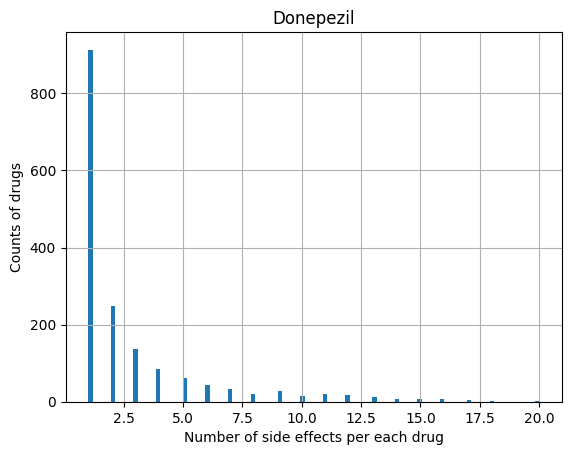

In [25]:
partial_df1.sum().hist(bins=100)
plt.xlabel('Number of side effects per each drug')
plt.ylabel('Counts of drugs')
plt.title('{}'.format(current_drug.capitalize()))

In [26]:
partial_df1.sum().sort_values(ascending=False,axis=0).head(60)

Vomiting                                                20
Nausea                                                  20
Headache                                                18
Diarrhoea                                               18
Dizziness                                               18
Rash                                                    17
Asthenia                                                17
Dermatitis                                              17
Hypersensitivity                                        17
Feeling abnormal                                        16
Body temperature increased                              16
Hypotension                                             16
Dyspnoea                                                16
Anaemia                                                 16
Musculoskeletal discomfort                              16
Thrombocytopenia                                        16
Pruritus                                                

In [27]:
fn='./result_files/create_SIDER_side_effect_data/side_effect_information_aggregated_by_side_effects_{}.csv'.format(current_drug)
partial_df1.sum().sort_values(ascending=False,axis=0).to_frame().reset_index().to_csv(fn,sep=',',encoding='utf-8',index=False)

In [28]:
df_sum_axis_1=partial_df1.sum(axis=1).sort_values(ascending=False,axis=0).to_frame()
df_sum_axis_1

,0
filtered_drug,
tramadol,627
bortezomib,622
paclitaxel,445
medroxyprogesterone,431
cyclophosphamide,318
docetaxel,302
etoricoxib,246
fenofibrate,229
cisplatin,161


In [29]:
fn='./result_files/create_SIDER_side_effect_data/side_effect_information_aggregated_by_drugs_{}.csv'.format(current_drug)
partial_df1.sum(axis=1).sort_values(ascending=False,axis=0).to_frame().reset_index().to_csv(fn,sep=',',encoding='utf-8',index=False)

In [30]:
df_final = pd.merge(df_candidates_filtered_by_DEG_agnostic_attached_side_effect[["filtered_drug","filtered_drug_expression","cosine_similarity"]], df_sum_axis_1, left_on="filtered_drug", right_index=True, how='inner')
df_final.columns=['filtered_drug','filtered_drug_expression','cosine_similarity','number_of_side_effects']

pd.set_option('display.float_format','{:.3f}'.format)
df_final.sort_values(by=['cosine_similarity','filtered_drug_expression','number_of_side_effects'], ascending=[False, True, True],axis=0)
df_final

,filtered_drug,filtered_drug_expression,cosine_similarity,number_of_side_effects
0,nelarabine,-0.305,0.386,151
1,ixabepilone,-1.286,0.373,150
2,neostigmine,-0.294,0.284,84
3,cabazitaxel,-1.760,0.283,140
4,etoricoxib,-0.403,0.283,246
5,medroxyprogesterone,-0.318,0.234,431
6,streptozotocin,-0.402,0.229,58
7,carteolol,-0.281,0.212,46
8,docetaxel,-0.914,0.197,302
9,cefaclor,-0.324,0.170,160


In [31]:
fn='./result_files/create_SIDER_side_effect_data/final_embedding_DEG_side_effect_DR_{}.csv'.format(current_drug)
df_final.to_csv(fn,sep=',',encoding='utf-8',index=False)